# Info

vip: inhibitory neurons.
- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions. 
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id. 

# Reminders

1- is the difference in age cause any deviation?.
2- is difference in sex cause any difference?

# Setup

In [14]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

In [15]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import numpy as np
import collections


import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

## Linked list

In [26]:
# A single node of a singly linked list
class Node:
  # constructor
  def __init__(self, data = None, next=None): 
    self.data = data
    self.next = next

# A Linked List class with a single head node
class LinkedList:
  def __init__(self):  
    self.head = None
  
  # insertion method for the linked list
  def insert(self, data):
    newNode = Node(data)
    if(self.head):
        newNode.next=self.head
        self.head=newNode
    else:
        self.head = newNode
  
  # print method for the linked list
  def printLL(self):
    current = self.head
    while(current):
      print(current.data)
      current = current.next

# Singly Linked List with insertion and print methods


In [27]:
LL = LinkedList()
LL.insert(3)
LL.insert(4)
LL.insert(5)


current = LL.head
while(current):
  print(current.data)
  current = current.next

5
4
3


# Loading experiment and session table

In [16]:
data_storage_directory = "temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

In [17]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

In [5]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


In [5]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


# Downloading certain sesssions

getting sample session from different familiarity levels

In [18]:
x1=np.array([0,1])
x2=np.arange(2,65,2)
x3=np.concatenate((x1,x2))
fam_groups=np.array(x3)



In [19]:
downloadable_sesssions=[]
for fam_lvl in np.arange(0,65,2):
    for x in experiment_table[((experiment_table['prior_exposures_to_image_set']==fam_lvl)&(experiment_table['full_genotype'].str.contains('Vip'))) ]['ophys_session_id'][0:2]:
         downloadable_sesssions.append(x)

In [20]:
experiments = {}
for tmp_ophys_session_id in downloadable_sesssions:
    ophys_experiment_ids = session_table.loc[tmp_ophys_session_id]['ophys_experiment_id']
    for ophys_experiment_id in ophys_experiment_ids:
        experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)


In [ ]:
for s in downloadable_sesssions:
    print(experiment_table[experiment_table['ophys_session_id']==s].index.values)
    print(experiment_table[experiment_table['ophys_session_id']==s]['prior_exposures_to_image_set'].unique())    
    print("#######")

In [21]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    print(ophys_experiment_id)
    #Here some experiments gives error while downloading them, 'it can't open file under the name ...` so i excluded them
    try:
        this_experiment = experiments[ophys_experiment_id]
        this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    except:
        print(ophys_experiment_id,': OUT')
        continue
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'imaging_depth',
        'stimulus_frame_rate',
        'mouse_id',
        'sex',
        'age_in_days',
        'targeted_structure',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

  0%|          | 0/86 [00:00<?, ?it/s]

795953296


  1%|          | 1/86 [00:09<13:54,  9.82s/it]

830093338


  2%|▏         | 2/86 [00:39<30:03, 21.47s/it]

796308505


  3%|▎         | 3/86 [00:51<23:41, 17.12s/it]

938001540


  5%|▍         | 4/86 [00:57<17:40, 12.93s/it]

833631914


  6%|▌         | 5/86 [01:06<15:20, 11.36s/it]

940354181


  7%|▋         | 6/86 [01:13<13:04,  9.81s/it]

1071070929


  8%|▊         | 7/86 [01:20<11:54,  9.04s/it]

1056171522


  9%|▉         | 8/86 [01:27<10:39,  8.20s/it]

1056171531


 10%|█         | 9/86 [01:34<10:16,  8.01s/it]

1065523118


 12%|█▏        | 10/86 [01:45<11:14,  8.87s/it]

992868972


 13%|█▎        | 11/86 [01:52<10:31,  8.42s/it]

993590480
993590480 : OUT
1065966776


 15%|█▌        | 13/86 [02:02<08:15,  6.79s/it]

1003444808


 16%|█▋        | 14/86 [02:13<09:17,  7.74s/it]

1067133170


 17%|█▋        | 15/86 [02:21<09:23,  7.94s/it]

1004136916


 19%|█▊        | 16/86 [02:33<10:35,  9.08s/it]

836911939


 20%|█▉        | 17/86 [02:44<10:51,  9.44s/it]

1004889552


 21%|██        | 18/86 [02:52<10:10,  8.97s/it]

945473009


 22%|██▏       | 19/86 [03:01<10:05,  9.03s/it]

847267616


 23%|██▎       | 20/86 [03:11<10:11,  9.27s/it]

847267622


 24%|██▍       | 21/86 [03:17<09:01,  8.34s/it]

847267624


 26%|██▌       | 22/86 [03:27<09:34,  8.98s/it]

847267626


 27%|██▋       | 23/86 [03:37<09:40,  9.22s/it]

847267628


 28%|██▊       | 24/86 [03:42<08:09,  7.90s/it]

847267630


 29%|██▉       | 25/86 [03:52<08:40,  8.53s/it]

798404219


 30%|███       | 26/86 [04:00<08:19,  8.33s/it]

948507789


 31%|███▏      | 27/86 [04:09<08:34,  8.73s/it]

960953590


 33%|███▎      | 28/86 [04:21<09:21,  9.68s/it]

932331541


 34%|███▎      | 29/86 [04:32<09:26,  9.94s/it]

962473308


 35%|███▍      | 30/86 [04:38<08:19,  8.93s/it]

934476801


 36%|███▌      | 31/86 [04:50<08:56,  9.75s/it]

942596349


 37%|███▋      | 32/86 [04:56<07:47,  8.66s/it]

942596353


 38%|███▊      | 33/86 [05:07<08:06,  9.19s/it]

942596355


 40%|███▉      | 34/86 [05:18<08:32,  9.85s/it]

942596357


 41%|████      | 35/86 [05:25<07:36,  8.95s/it]

942596359


 42%|████▏     | 36/86 [05:36<08:03,  9.68s/it]

942596361


 43%|████▎     | 37/86 [05:46<07:58,  9.77s/it]

942596363


 44%|████▍     | 38/86 [05:51<06:38,  8.30s/it]

1052412559


 45%|████▌     | 39/86 [06:00<06:41,  8.55s/it]

1052412568


 47%|████▋     | 40/86 [06:11<07:10,  9.36s/it]

881001210


 48%|████▊     | 41/86 [06:17<06:10,  8.22s/it]

881001212


 49%|████▉     | 42/86 [06:28<06:37,  9.03s/it]

881001216


 50%|█████     | 43/86 [06:38<06:43,  9.38s/it]

881001218


 51%|█████     | 44/86 [06:46<06:19,  9.04s/it]

882551933


 52%|█████▏    | 45/86 [06:58<06:36,  9.66s/it]

882551935


 53%|█████▎    | 46/86 [07:10<06:55, 10.38s/it]

882551937


 55%|█████▍    | 47/86 [07:14<05:38,  8.68s/it]

882551939


 56%|█████▌    | 48/86 [07:25<05:54,  9.34s/it]

882551943


 57%|█████▋    | 49/86 [07:37<06:08,  9.97s/it]

882551945


 58%|█████▊    | 50/86 [07:44<05:26,  9.07s/it]

882551947


 59%|█████▉    | 51/86 [07:54<05:32,  9.50s/it]

882551950


 60%|██████    | 52/86 [08:06<05:45, 10.17s/it]

916803619


 62%|██████▏   | 53/86 [08:11<04:44,  8.63s/it]

916803621


 63%|██████▎   | 54/86 [08:21<04:54,  9.21s/it]

916803626


 64%|██████▍   | 55/86 [08:32<04:57,  9.59s/it]

967008454


 65%|██████▌   | 56/86 [08:38<04:15,  8.50s/it]

1049610116


 66%|██████▋   | 57/86 [08:48<04:22,  9.06s/it]

1049610120


 67%|██████▋   | 58/86 [08:59<04:31,  9.71s/it]

1049610123


 69%|██████▊   | 59/86 [09:04<03:40,  8.17s/it]

1049610125


 70%|██████▉   | 60/86 [09:14<03:49,  8.81s/it]

1049610126


 71%|███████   | 61/86 [09:25<03:53,  9.33s/it]

1049610129


 72%|███████▏  | 62/86 [09:29<03:09,  7.91s/it]

920288843


 73%|███████▎  | 63/86 [09:40<03:21,  8.77s/it]

920288845


 74%|███████▍  | 64/86 [09:45<02:47,  7.63s/it]

920288849


 76%|███████▌  | 65/86 [09:56<03:02,  8.69s/it]

920288851


 77%|███████▋  | 66/86 [10:07<03:06,  9.32s/it]

920288853


 78%|███████▊  | 67/86 [10:12<02:33,  8.09s/it]

920288855


 79%|███████▉  | 68/86 [10:23<02:38,  8.82s/it]

939471245


 80%|████████  | 69/86 [10:34<02:42,  9.55s/it]

939471248


 81%|████████▏ | 70/86 [10:39<02:10,  8.16s/it]

939471250


 83%|████████▎ | 71/86 [10:50<02:16,  9.09s/it]

939471256


 84%|████████▎ | 72/86 [11:01<02:13,  9.52s/it]

939471259


 85%|████████▍ | 73/86 [11:06<01:47,  8.26s/it]

944115804


 86%|████████▌ | 74/86 [11:19<01:56,  9.73s/it]

944115808
944115808 : OUT
944115814


 88%|████████▊ | 76/86 [11:24<01:03,  6.37s/it]

944115820


 90%|████████▉ | 77/86 [11:38<01:14,  8.25s/it]

944115825


 91%|█████████ | 78/86 [11:50<01:13,  9.19s/it]

944115831


 92%|█████████▏| 79/86 [11:55<00:56,  8.13s/it]

939471269


 93%|█████████▎| 80/86 [12:07<00:54,  9.03s/it]

939471272


 94%|█████████▍| 81/86 [12:18<00:48,  9.77s/it]

939471278


 95%|█████████▌| 82/86 [12:24<00:33,  8.49s/it]

939471282


 97%|█████████▋| 83/86 [12:36<00:28,  9.47s/it]

939471285


 98%|█████████▊| 84/86 [12:47<00:20, 10.12s/it]

939471290


 99%|█████████▉| 85/86 [12:52<00:08,  8.47s/it]

939471298


100%|██████████| 86/86 [13:04<00:00,  9.13s/it]


In [ ]:
#Number of neurons

Experiment couldn't be downloaded: 993590480

In [10]:
neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,imaging_depth,stimulus_frame_rate,mouse_id,sex,age_in_days,targeted_structure
0,3.17722,0.665995,0.0,0.0,1080895959,1086493416,795953296,795625712,175,60.0,412036,F,162,VISp
1,3.20953,0.319544,0.0,0.0,1080895959,1086493416,795953296,795625712,175,60.0,412036,F,162,VISp
2,3.24183,0.568772,0.0,0.0,1080895959,1086493416,795953296,795625712,175,60.0,412036,F,162,VISp
3,3.27414,0.414089,0.0,0.0,1080895959,1086493416,795953296,795625712,175,60.0,412036,F,162,VISp
4,3.30644,0.352505,0.0,0.0,1080895959,1086493416,795953296,795625712,175,60.0,412036,F,162,VISp


# Splitting the experiments ids

Getting all experiments ids with same familiarty level into one group

In [22]:
exp_ids_groups={}
cnt=0
for i in range(len(fam_groups)):
    current_fam=fam_groups[i]    
    if fam_groups[i]==0:
        exp_ids_groups[current_fam]=experiment_table.loc[experiment_table['prior_exposures_to_image_set']==0].index.values
    else:
        try:
            next_fam=fam_groups[i+1]
            exp_ids_groups[current_fam]=experiment_table.loc[((experiment_table['prior_exposures_to_image_set']>=current_fam)  & (experiment_table['prior_exposures_to_image_set']<next_fam))].index.values
        except:
            exp_ids_groups[current_fam]=experiment_table.loc[(experiment_table['prior_exposures_to_image_set']>=current_fam)].index.values

In [23]:
full_cat_exp_id={}
for key in exp_ids_groups.keys():
  #Now we have key could be 0,1,2,4,6,810,12,14,......
  if not key in full_cat_exp_id:
    tmp_dict={}
    tmp_dict[key]={}
    full_cat_exp_id[key]=tmp_dict

  current_ids_in_key=exp_ids_groups[key]# all ids in specific key
  for exp_id in current_ids_in_key:
    if experiment_table.loc[exp_id,'full_genotype'][0:3]=='Vip':
      if 'Vip' in full_cat_exp_id[key]:
        full_cat_exp_id[key]['Vip']=np.concatenate([full_cat_exp_id[key]['Vip'],[exp_id] ])
      else:
        full_cat_exp_id[key]['Vip']=np.array([exp_id])

    if experiment_table.loc[exp_id,'full_genotype'][0:3]=='Slc':
      if 'Slc' in full_cat_exp_id[key]:
        full_cat_exp_id[key]['Slc']=np.concatenate([full_cat_exp_id[key]['Slc'],[exp_id] ])
      else:
        full_cat_exp_id[key]['Slc']=np.array([exp_id])
        
    if experiment_table.loc[exp_id,'full_genotype'][0:3]=='Sst':
      if 'Sst' in full_cat_exp_id[key]:
        full_cat_exp_id[key]['Sst']=np.concatenate([full_cat_exp_id[key]['Sst'],[exp_id] ])
      else:
        full_cat_exp_id[key]['Sst']=np.array([exp_id])
        
print(full_cat_exp_id)


{0: {0: {}, 'Sst': array([ 957759562,  957759576,  957759572,  957759566,  957759574,
        957759570,  957759564,  994955425,  965228792, 1051423446,
       1008318518,  993344860,  982183920, 1044095203,  978296100,
        978296104,  978296102,  978296114,  978296110,  853363749,
        853363743,  853363745,  853363756,  853363751,  853363747,
        853363739,  988542529]), 'Vip': array([ 795953296,  830093338,  968651977, 1050762972, 1050762969,
       1050762966, 1050762977, 1050762974, 1050762975,  950833329,
        932372699,  932372707,  932372711,  932372701,  932372705,
       1067647876, 1067648397, 1053997501,  993862120,  849233390,
        849233398,  849233402,  849233396,  849233404,  849233400,
        882968566,  882968574,  882968568,  882968562,  882968564,
        948689207,  948689205,  948689203,  948689192,  948689198,
        948689196, 1004403369, 1005123568,  877669824,  877669819,
        877669826,  877669815,  877669811,  877669817,  877669822,
   

In [24]:
full_cat_exp_id_cells={}
for i in fam_groups:
    try:
        current_vip_ids=full_cat_exp_id[i]['Vip']
        full_cat_exp_id_cells.update({i:{}})
        full_cat_exp_id_cells[i].update({'Vip':{}})
        for vip_exp_id in current_vip_ids:
            cell_ids= neural_data[neural_data['ophys_experiment_id']==vip_exp_id]['cell_specimen_id'].unique()
            full_cat_exp_id_cells[i]['Vip'].update({vip_exp_id:np.array(cell_ids)})
    except:
        print(i,'#####')


            

8 #####
30 #####
38 #####
40 #####
58 #####
60 #####
62 #####
64 #####


there are certain familiarty levels that don't have vip nueron which are: 8,30,38,40,58,60,62,64

In [ ]:
print(full_cat_exp_id_cells)

In [26]:
#Number of neurons
count=0
for lvl in fam_groups:
    
    if lvl in full_cat_exp_id_cells.keys():
        for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
            if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0:
                for n_id in full_cat_exp_id_cells[lvl]['Vip'][exp_key]:
                    count +=1
print(count)

1574


## Getting average of each familiarty level in all neurons

i choose 550 as this the average for number of times till they change it.

In [ ]:
resp={}
max_resp={}
min_resp={}
common_start_time=310
num_of_iter=550


for lvl in fam_groups:
    resp.update({lvl:{}})
    max_resp.update({lvl:{}})
    min_resp.update({lvl:{}})
    if lvl in full_cat_exp_id_cells.keys():
        for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
            if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0:
                stimulus_table_tmp = experiments[exp_key].stimulus_presentations.drop(columns = ['image_set']) 
                lst_lat=[]
                lst_max=[]
                lst_min=[]
                for n_id in full_cat_exp_id_cells[lvl]['Vip'][exp_key]:
                    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
                    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==exp_key)&(neural_data['cell_specimen_id']==n_id)&(neural_data['timestamps']>start_time_stimuli))]

                    max_size=0
                    #get max size of array(Approximation)
                    for i in range(0,num_of_iter):
                        tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                        max_size=max(max_size,len(tmp_tst['dff'].values))

                    count=0;
                    avg_resp={'resp':np.zeros(max_size)}
                    for i in range(0,num_of_iter):
                        tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                        for j in range(len(tmp_tst['dff'].values)):
                            avg_resp['resp'][j] +=tmp_tst['dff'].values[j]
                        if not tmp_tst['timestamps'].values.size==0:
                                count +=1

                    response=(avg_resp['resp']/count)
                    time=np.linspace(0,0.75,len(response))
                    lst_lat.append(time[np.where(response == np.amax(response))])
                    lst_max.append(max(response))
                    lst_min.append(min(response))
                tmp_dict={exp_key:np.array(lst_lat).mean()}
                tmp_dict_max={exp_key:np.array(lst_max).mean()}
                tmp_dict_min={exp_key:np.array(lst_min).mean()}
                resp[lvl].update(tmp_dict)
                max_resp[lvl].update(tmp_dict_max)
                min_resp[lvl].update(tmp_dict_min)
print(resp)






In [53]:
avg=[]
for lvl in fam_groups:
    exps=list(resp[lvl].keys())
    lat_in_lvl=[]
    for exp in exps:
        vals=np.array(resp[lvl][exp]).mean()
        lat_in_lvl.append(vals)
    avg.append(np.mean(lat_in_lvl))

In [54]:
avg_max=[]
for lvl in fam_groups:
    exps=list(max_resp[lvl].keys())
    max_in_lvl=[]
    for exp in exps:
        vals=np.array(max_resp[lvl][exp]).mean()
        max_in_lvl.append(vals)
    avg_max.append(np.mean(max_in_lvl))
    
avg_min=[]
for lvl in fam_groups:
    exps=list(min_resp[lvl].keys())
    min_in_lvl=[]
    for exp in exps:
        vals=np.array(min_resp[lvl][exp]).mean()
        min_in_lvl.append(vals)
    avg_min.append(np.mean(min_in_lvl))




Dropping nan values.

In [62]:
import math 
fam_groups_opt=[]
avg_opt=[]
avg_max_opt=[]
avg_min_opt=[]


for i in range(len(fam_groups)):
    if not math.isnan(avg[i]):
        fam_groups_opt.append(fam_groups[i])
        avg_opt.append(avg[i])
        avg_max_opt.append(avg_max[i])
        avg_min_opt.append(avg_min[i])
        
    


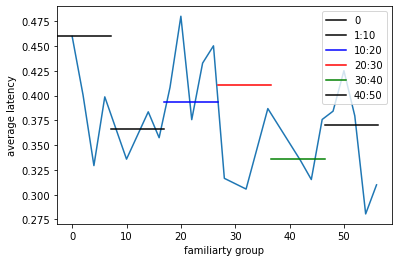

In [122]:
plt.plot(fam_groups_opt,avg_opt)
plt.xlabel('familiarty group')
plt.ylabel('average latency')


plt.axhline(y=avg_opt[0], xmin=0, xmax=0.16,color='k',label='0')    
#average from 1:10
ind_1=[]
for i in range(1,len(fam_groups_opt)):
    if fam_groups_opt[i]>10:
        break
    ind_1.append(i)
avg_1=[]
for i in ind_1:
    avg_1.append(avg_opt[i])
plt.axhline(y=np.array(avg_1).mean(), xmin=0.16, xmax=0.32,color='k',label='1:10')  


ind_2=[]
for i in range(ind_1[-1],len(fam_groups_opt)):
    if fam_groups_opt[i]>20:
        break
    ind_2.append(i)
avg_2=[]
for i in ind_2:
    avg_2.append(avg_opt[i])
plt.axhline(y=np.array(avg_2).mean(), xmin=0.32, xmax=0.48,color='b',label='10:20')  

ind_3=[]
for i in range(ind_2[-1],len(fam_groups_opt)):
    if fam_groups_opt[i]>30:
        break
    ind_3.append(i)
avg_3=[]
for i in ind_3:
    avg_3.append(avg_opt[i])
plt.axhline(y=np.array(avg_3).mean(), xmin=0.48, xmax=0.64,color='r',label='20:30')  

ind_4=[]
for i in range(ind_3[-1],len(fam_groups_opt)):
    if fam_groups_opt[i]>40:
        break
    ind_4.append(i)
avg_4=[]
for i in ind_4:
    avg_4.append(avg_opt[i])
plt.axhline(y=np.array(avg_4).mean(), xmin=0.64, xmax=0.8,color='g',label='30:40') 

ind_5=[]
for i in range(ind_4[-1],len(fam_groups_opt)):
    if fam_groups_opt[i]>50:
        break
    ind_5.append(i)
avg_5=[]
for i in ind_5:
    avg_5.append(avg_opt[i])
plt.axhline(y=np.array(avg_5).mean(), xmin=0.8, xmax=0.96,color='k',label='40:50') 
plt.legend()







[0.4597332015810277, 0.36615415466632584, 0.3930840373486495, 0.41108280780387557, 0.3363568475571667, 0.37035790646288896]
[0, 1, 10, 20, 30, 40]
(6,)
(6,)


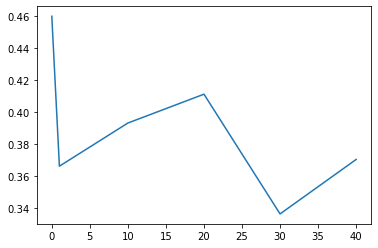

In [138]:
_=[
    avg_opt[0],np.array(avg_1).mean(),np.array(avg_2).mean(),np.array(avg_3).mean(),np.array(avg_4).mean(),np.array(avg_5).mean()
]
__=[0,1,10,20,30,40]
print(_)
print(__)
print(np.array(_).shape)
print(np.array(__).shape)
plt.plot(__,_)
         

Text(0, 0.5, 'max dff')

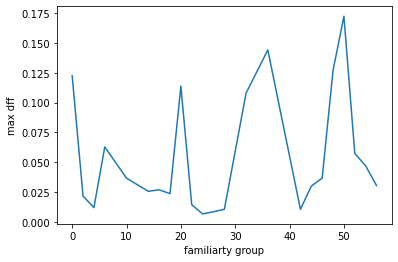

In [64]:
plt.plot(fam_groups_opt,avg_max_opt)
plt.xlabel('familiarty group')
plt.ylabel('max dff')

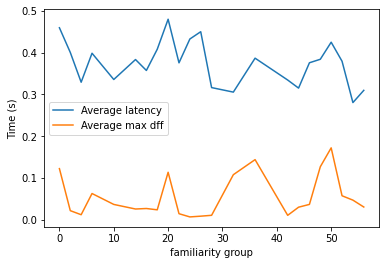

In [66]:
plt.plot(fam_groups_opt,avg_opt,label='Average latency')

plt.plot(fam_groups_opt,avg_max_opt,label='Average max dff')
plt.xlabel('familiarity group')
plt.ylabel('Time (s)')
plt.legend()




this doesn't give great results. as the latency reponse does not decrease in great amount after showing large number of showing the image. the algorithm might be wrong.

## Calculating the latency response in different way.

In [80]:
fam_groups_alg_2=[0,1,10,20,30,40,50]

resp_alg_2={}
max_resp_alg_2={}
common_start_time=310
num_of_iter=550


for i in range(len(fam_groups_alg_2)):
    try:
        current_lvl=fam_groups_alg_2[i]
        next_lvl=fam_groups_alg_2[i+1]
        lvl_downloaded=fam_groups[np.where((fam_groups>=current_lvl)&(fam_groups<next_lvl))]
        for spec_lvl in lvl_downloaded:
            if lvl in full_cat_exp_id_cells.keys():
                for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
                    if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0:
    except:
        pass

0 1
[0]
1 10
[1 2 4 6 8]
10 20
[10 12 14 16 18]
20 30
[20 22 24 26 28]
30 40
[30 32 34 36 38]
40 50
[40 42 44 46 48]


## Two dots for max dff considering prior exposure to image set only.

In [ ]:
novel_dff= LinkedList()
fam_dff=LinkedList()

common_start_time=310
num_of_iter=550


for lvl in fam_groups:
       if lvl in full_cat_exp_id_cells.keys():
        for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
            if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0:
                stimulus_table_tmp = experiments[exp_key].stimulus_presentations
                stimulus_table_tmp=stimulus_table_tmp[stimulus_table_tmp['image_name']=='im000']
                for n_id in full_cat_exp_id_cells[lvl]['Vip'][exp_key]:
                    stimuli_presentatoins_times=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values
                    presnet_count=0;
                    for start_time in stimuli_presentatoins_times:
                        tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==exp_key)&(neural_data['cell_specimen_id']==n_id)&(neural_data['timestamps']>=start_time)&(neural_data['timestamps']<start_time+0.75))]
                        response= tmp_test__['dff'].values
                        if presnet_count==0:
                            novel_dff.insert(max(response))
                        else:
                            fam_dff.insert(max(response))
                            presnet_count =1





                                

In [ ]:

count_dff_novel=0
sum_dff_novel=0

current = novel_dff.head
while(current):
    count_dff_novel +=1
    sum_dff_novel +=current.data       
    current = current.next
mean_novel_dff=sum_dff_novel/count_dff_novel

In [ ]:

count_dff_fam=0
sum_dff_fam=0

current = fam_dff.head
while(current):
    count_dff_fam +=1
    sum_dff_fam +=current.data       
    current = current.next
mean_fam_dff=sum_dff_fam/count_dff_fam


In [ ]:
print(mean_novel_dff)
print(mean_fam_dff)
plt.plot([0,1],[mean_novel_dff,mean_fam_dff])
plt.xlabel('familiarity')
plt.ylabel('average max dff')



## Two dots for every different targeted structure(VISp)


In [ ]:
#targeted_structure
novel_lat_visp=LinkedList()
fam_lat_visp=LinkedList()
max_dff_visp=LinkedList()

common_start_time=310
num_of_iter=550
              



for lvl in fam_groups:
       if lvl in full_cat_exp_id_cells.keys():
        for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
            if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0 and expermintal_table.loc[exp_key,'targeted_structure']=='VISp':
                stimulus_table_tmp = experiments[exp_key].stimulus_presentations
                for n_id in full_cat_exp_id_cells[lvl]['Vip'][exp_key]:
                    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
                    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==exp_key)&(neural_data['cell_specimen_id']==n_id)&(neural_data['timestamps']>start_time_stimuli))]

                    max_size=26#
                    count=0;
                    avg_resp={'resp':np.zeros(max_size)}
                    for i in range(0,num_of_iter):
                        tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                        for j in range(len(tmp_tst['dff'].values)):
                            avg_resp['resp'][j] +=tmp_tst['dff'].values[j]
                        if not tmp_tst['timestamps'].values.size==0:
                                count +=1

                    response=(avg_resp['resp']/count)
                    time=np.linspace(0,0.75,len(response))
                    
                                    
                    if lvl==0:
                        novel_lat_visp.insert(time[np.where(response == np.amax(response))])
                        max_dff_visp.insert(max(response))
                    else:
                        fam_lat_visp.insert(time[np.where(response == np.amax(response))])
                        max_dff_visp.insert(max(response))





                                

In [ ]:
count_dff_novel_visp=0
sum_dff_novel_visp=0

current = max_dff_visp.head
while(current):
    count_dff_novel_visp +=1
    sum_dff_novel_visp +=current.data       
    current = current.next
mean_max_dff_visp=sum_dff_novel_visp/count_dff_novel_visp

In [ ]:
count_fam_lat_visp=0
sum_fam_lat_visp=0

current = fam_lat_visp.head
while(current):
    count_fam_lat_visp +=1
    sum_fam_lat_visp +=current.data       
    current = current.next
mean_fam_lat_visp=sum_fam_lat_visp/count_fam_lat_visp

In [ ]:
count_novel_lat_visp=0
sum_novel_lat_visp=0

current = novel_lat_visp.head
while(current):
    count_novel_lat_visp +=1
    sum_novel_lat_visp +=current.data       
    current = current.next
mean_novel_lat_visp=sum_novel_lat_visp/count_novel_lat_visp

# Two dots considering prior exposure to image set only.

In [250]:
novel_lat=[]
fam_lat=[]

common_start_time=310
num_of_iter=550


for lvl in fam_groups:
       if lvl in full_cat_exp_id_cells.keys():
        for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
            if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0:
                stimulus_table_tmp = experiments[exp_key].stimulus_presentations.drop(columns = ['image_set']) 
                lst_lat=[]
                for n_id in full_cat_exp_id_cells[lvl]['Vip'][exp_key]:
                    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
                    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==exp_key)&(neural_data['cell_specimen_id']==n_id)&(neural_data['timestamps']>start_time_stimuli))]

                    max_size=0
                    #get max size of array(Approximation)
                    for i in range(0,num_of_iter):
                        tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                        max_size=max(max_size,len(tmp_tst['dff'].values))

                    count=0;
                    avg_resp={'resp':np.zeros(max_size)}
                    for i in range(0,num_of_iter):
                        tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                        for j in range(len(tmp_tst['dff'].values)):
                            avg_resp['resp'][j] +=tmp_tst['dff'].values[j]
                        if not tmp_tst['timestamps'].values.size==0:
                                count +=1

                    response=(avg_resp['resp']/count)
                    time=np.linspace(0,0.75,len(response))
                    lst_lat.append(time[np.where(response == np.amax(response))])
                    
                if lvl==0:
                    novel_lat.append(np.array(lst_lat).mean())
                else:
                    fam_lat.append(np.array(lst_lat).mean())

mean_novel=np.array(novel_lat).mean()
mean_fam=np.array(fam_lat).mean()






                                

0.4597332015810277
0.36587796008985773


Text(0.5, 0, 'familiarity')

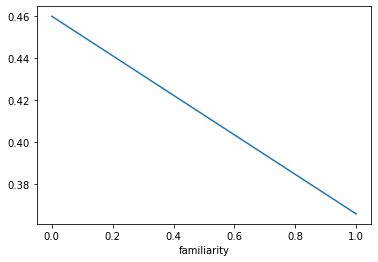

In [256]:
print(mean_novel)
print(mean_fam)
plt.plot([0,1],[mean_novel,mean_fam])
plt.xlabel('familiarity')
#plt.ylalbel('avg latency response')

## Two dots 500 flashes only

In [ ]:
novel_lat_500=[]
fam_lat_500=[]

common_start_time=310
num_of_iter=550


for lvl in fam_groups:
       if lvl in full_cat_exp_id_cells.keys():
        for exp_key in full_cat_exp_id_cells[lvl]['Vip'].keys():
            if not full_cat_exp_id_cells[lvl]['Vip'][exp_key].size==0:
                
                stimulus_table_tmp = experiments[exp_key].stimulus_presentations
                stimulus_table_tmp=stimulus_table_tmp[stimulus_table_tmp['image_name']=='im000']
                #lst_lat=[]
                for n_id in full_cat_exp_id_cells[lvl]['Vip'][exp_key]:
                    stimuli_presentatoins_times=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values
                    #lst_lat_stim=[]
                    presnet_count=0;
                    for start_time in stimuli_presentatoins_times:
                        
                        tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==exp_key)&(neural_data['cell_specimen_id']==n_id)&(neural_data['timestamps']>=start_time)&(neural_data['timestamps']<start_time+0.75))]
                        
                        #max_size=26
                        #lst_lat_stim.append(time[np.where(response == np.amax(tmp_test__['dff'].values))])
                    
                        ######
                        #lst_lat.append(np.array(lst_lat_stim).mean())
                        response= tmp_test__['dff'].values
                        time=np.linspace(0,0.75,len(response))
                        if presnet_count==0:
                            novel_lat_500.append(time[np.where(response == np.amax(response))])
                        else:
                            fam_lat_500.append(time[np.where(response == np.amax(response))])
                            presnet_count =1
                        
            
                
                    
                    
                    
mean_novel_500=np.array(novel_lat_500).mean()
mean_fam_500=np.array(fam_lat_500).mean()



In [ ]:
plt.plot([0,1],[mean_novel_500,mean_fam_500])
plt.xlabel('familiarity')
plt.ylalbel('avg latency response')

## Only for testing

In [43]:
#print(full_cat_exp_id_cells)
stimulus_table_tmp = experiments[795953296].stimulus_presentations
print(stimulus_table_tmp['image_name'].unique())
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='im000']))
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='im073']))
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='im054']))
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='im035']))
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='im106']))
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='omitted']))
print(len(stimulus_table_tmp[stimulus_table_tmp['image_name']=='im075']))


['im000' 'im073' 'im054' 'im035' 'im106' 'omitted' 'im075' 'im031' 'im045']
493
479
604
535
571
170
672


In [60]:
print(fam_groups_opt)
print(avg_opt)

[0, 2, 4, 6, 10, 14, 16, 18, 20, 22, 24, 26, 28, 32, 36, 42, 44, 46, 48, 50, 52, 54, 56]
[0.4597332015810277, 0.40064671353491227, 0.32936381074168797, 0.3987365291713118, 0.3358695652173913, 0.38363742236024845, 0.3575109766545298, 0.40828804347826086, 0.48011417903281706, 0.375746536072623, 0.43280632411067194, 0.4502508361204013, 0.31649616368286443, 0.3056696170838737, 0.3869047619047619, 0.33459238406183367, 0.31528669084821426, 0.3759191176470588, 0.38428730187727267, 0.4251571824381926, 0.3795704219187675, 0.28058379120879123, 0.30991586538461535]


Text(0.5, 1.0, '1-10 level')

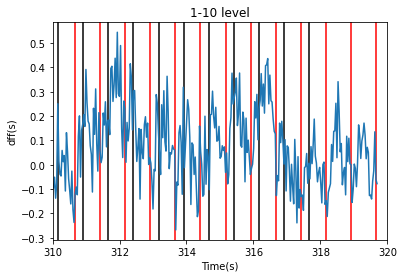

In [139]:
experiment_id=795953296
neuro_id=1086490480
common_start_time=310
tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
start_time_for_neural=tmp_test__['timestamps'].values[0]

stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]
for time in stimulus_table_tmp['start_time'].values[start_index_stimulus:start_index_stimulus+15]:
     plt.axvline(x=time, ymin=0, ymax=1,color='r')

for time in stimulus_table_tmp['stop_time'].values[1:15]:
     plt.axvline(x=time, ymin=0, ymax=1,color='k')    

plt.plot(tmp_test__['timestamps'][0:300],tmp_test__['dff'][0:300])
plt.xlabel('Time(s)')
plt.ylabel('dff(s)')
plt.xlim((310,320))
plt.title('1-10 level')

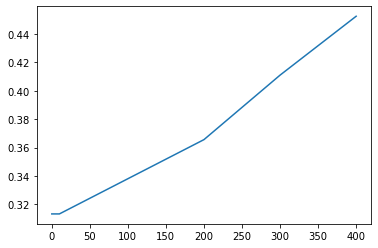

In [189]:


experiment_id=795953296
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[0]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

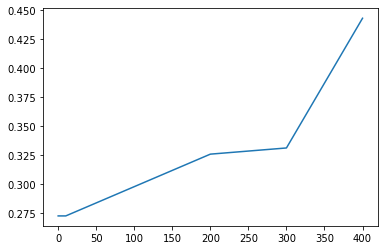

In [194]:

experiment_id=796308505
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[2]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

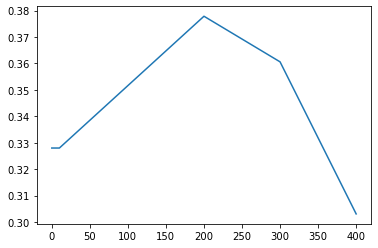

In [196]:

experiment_id=833631914
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[4]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

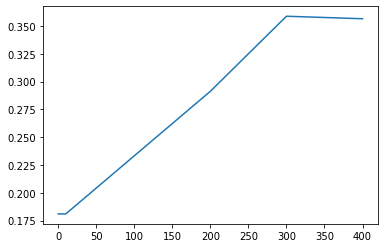

In [201]:

experiment_id=1067133170
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[16]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

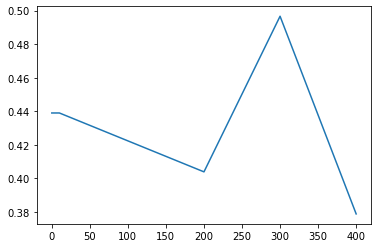

In [202]:

experiment_id=932331541
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[26]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

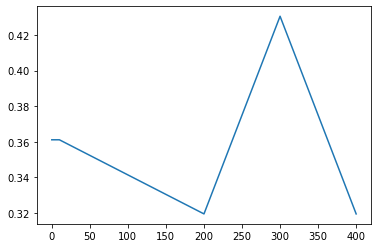

In [207]:

experiment_id=1052412559
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[36]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

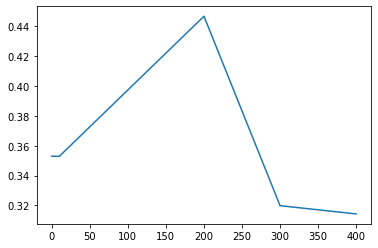

In [208]:

experiment_id=916803626
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[46]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

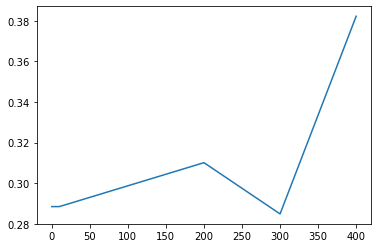

In [211]:

experiment_id=939471285
avg_of_avg={0:[],100:[],200:[],300:[],400:[],500:[]}
for neuro_id in full_cat_exp_id_cells[56]['Vip'][experiment_id]:
                     
    common_start_time=310

    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
    start_time_for_neural=tmp_test__['timestamps'].values[0]

    stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
    start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]



    fam_tst_groups=[0,100,200,300,400,500]

    start_time_stimuli=stimulus_table_tmp[stimulus_table_tmp['start_time']>=common_start_time]['start_time'].values[0]
    tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>start_time_stimuli))]


    avg_tst_resp=[]
    for lvl in range(6):
        try:
            current_fam_tst=fam_tst_groups[lvl]
            nxt_fam_tst=fam_tst_groups[lvl+1]
            max_size=0
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                max_size=max(max_size,len(tmp_tst['dff'].values))

            #avg_tst_resp.update({current_fam_tst:0})
            lst_lat=np.zeros(max_size)
            count=0;
            for i in range(current_fam_tst,nxt_fam_tst):
                tmp_tst=tmp_test__[((tmp_test__['timestamps']>=(i*0.75)+start_time_stimuli )&(tmp_test__['timestamps']<=((i*0.75)+start_time_stimuli+0.75)))]
                for j in range(len(tmp_tst['dff'].values)):
                    lst_lat[j] +=tmp_tst['dff'].values[j]
                if not tmp_tst['timestamps'].values.size==0:
                        count +=1


            response=(lst_lat/count)
            time=np.linspace(0,0.75,len(response))
            avg_tst_resp.append(time[np.where(response == np.amax(response))][0])
        except:
           pass
    avg_of_avg[0].append(avg_tst_resp[0])
    avg_of_avg[100].append(avg_tst_resp[0])
    avg_of_avg[200].append(avg_tst_resp[1])
    avg_of_avg[300].append(avg_tst_resp[2])
    avg_of_avg[400].append(avg_tst_resp[3])
    
avg_avg_opt=[]
avg_avg_opt.append(np.array(avg_of_avg[0]).mean())
avg_avg_opt.append(np.array(avg_of_avg[100]).mean())
avg_avg_opt.append(np.array(avg_of_avg[200]).mean())
avg_avg_opt.append(np.array(avg_of_avg[300]).mean())
avg_avg_opt.append(np.array(avg_of_avg[400]).mean())
plt.plot([0,10,200,300,400],avg_avg_opt)

In [210]:
print(full_cat_exp_id_cells[56]['Vip'])
#print(avg_tst_resp)

{939471285: array([1086614788, 1086617091, 1086612108, 1086611751, 1086611973,
       1086611616, 1086617154, 1086611370, 1086617281, 1086617333,
       1086612357, 1086611566, 1086617446, 1086613543, 1086611511,
       1086615332, 1086615171, 1086613390, 1086612839, 1086611875,
       1086612208, 1086615562, 1086614406, 1086613057, 1086613681,
       1086615071]), 939471298: array([1086614167, 1086612760, 1086613571, 1086619576, 1086622574,
       1086614561, 1086613892, 1086617380, 1086619162, 1086613421,
       1086613239, 1086616011, 1086614769, 1086614990, 1086615161,
       1086619643, 1086616538, 1086619782, 1086620847, 1086617850,
       1086615711, 1086616782, 1086616905, 1086615292]), 939471290: array([1086616916, 1086618263, 1086616372, 1086616570, 1086621207,
       1086618537]), 939471278: array([1086617963, 1086617759, 1086617479, 1086621143, 1086616882,
       1086617069, 1086619172, 1086616124, 1086615960, 1086616320,
       1086622167, 1086619386, 1086616552, 108661731

In [221]:
print(full_cat_exp_id_cells)


{0: {'Vip': {795953296: array([1086493416, 1086491936, 1086491347, 1086491059, 1086493697,
       1086491308, 1086490897, 1086491006, 1086491873, 1086490790,
       1086490745, 1086490937, 1086490441, 1086492307, 1086490480,
       1086490397, 1086490680, 1086490597, 1086490510, 1086492174,
       1086491165, 1086491195, 1086491237, 1086491281, 1086491757,
       1086491118, 1086492406, 1086491491, 1086491530, 1086492221,
       1086491597, 1086491653, 1086490719]), 830093338: array([1086493993, 1086493441, 1086493543, 1086493384, 1086494677,
       1086494581, 1086494760, 1086494176, 1086493808, 1086494288,
       1086494149, 1086494248, 1086492984, 1086492915, 1086495267,
       1086494076, 1086494537, 1086494863, 1086494804, 1086493148,
       1086493213, 1086493082]), 968651977: array([], dtype=int64), 1050762972: array([], dtype=int64), 1050762969: array([], dtype=int64), 1050762966: array([], dtype=int64), 1050762977: array([], dtype=int64), 1050762974: array([], dtype=int64), 10

Text(0.5, 1.0, '1-10 level')

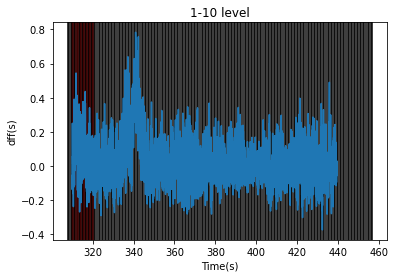

In [226]:
experiment_id=795953296
neuro_id=1086490480
common_start_time=310
tmp_test__ =neural_data[((neural_data['ophys_experiment_id']==experiment_id)&(neural_data['cell_specimen_id']==neuro_id)&(neural_data['timestamps']>common_start_time))]
start_time_for_neural=tmp_test__['timestamps'].values[0]

stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]
for time in stimulus_table_tmp['start_time'].values[start_index_stimulus:start_index_stimulus+15]:
     plt.axvline(x=time, ymin=0, ymax=1,color='r')

for time in stimulus_table_tmp['stop_time'].values[1:200]:
     plt.axvline(x=time, ymin=0, ymax=1,color='k')    

plt.plot(tmp_test__['timestamps'][0:4000],tmp_test__['dff'][0:4000])
plt.xlabel('Time(s)')
plt.ylabel('dff(s)')
#plt.xlim((310,320))
plt.title('1-10 level')


In [13]:
#stimulus_table_tmp = experiments[experiment_id].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.start_index_stimulus=stimulus_table_tmp[stimulus_table_tmp['start_time']>=start_time_for_neural-0.5].index[0]
#stimulus_table_tmp.head(500)
#stimulus_table_tmp[stimulus_table_tmp['is_change']==True].head(100)

print(stimulus_table_tmp['image_name'].values[0:300])

   

NameError: name 'stimulus_table_tmp' is not defined